In [ ]:
# This is the notebook for training and testing of DeepLabV3 model on Cityscape dataset
# It contains the custom dataset preparation class for Cityscape 
# As a model we are using DeepLabV3 model from default PyTorch librar
# Turn on GPU runtime as this is based on GPU enviornment

In [ ]:
# Import all required libaries

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from cv2 import imread
import cv2
import numpy as np
from statistics import mean as mean

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large as deeplab

torch.cuda.is_available()

True

In [ ]:
# For custom dataset prepare dataset directory as following:
# Dataset
#   |---target_images
#      |---test
#      |---train
#      |---val 
#   |---input_images
#      |---test
#      |---train
#      |---val
#   |---list 
#      |---train.lst
#      |---test.lst
#      |---val.lst

# The train.lst, test.lst and val.lst is a text file which contains the path to each individual image 
# For reference visit following drive folder to see cityscape_dataset format 
# https://drive.google.com/drive/folders/17ZsN-ebrWTxS7q1yMkzOJYIAt6EBkhzT?usp=sharing 

# In general for segmentation the model takes image in [N, C, H, W] dimension and generate output array of size 
# [class, H, W]. In case of cityscape we have total 30 class, so the input matrix has shape of [N, 3, 1024, 2048] and 
# output matrix of shape [30, 1024, 2048]
# In output matrix each pixel has shape equal to no of classes and each element of that array represent value for each class.
# After taking argmax of each pixel we will get id of that class and final image array will contain only [H, W] with each pixel has
# class id.

# In dataset we have input and target image. The target image need to convert into classID array. 
# In cityscape dataset: gray_valuye = (0.299*R + 0.587*G + 0.114*B)

#     class_id = gray_value = color_value = objects

#     0 = 0 = (0, 0, 0) = unlabeled, ego vehicle, rectification border, out of roi, static
#     1 = 8 = (0, 0, 70) = truck
#     2 = 10 = (0, 0, 90) = caravan
#     3 = 13 = (0, 0, 110) = trailer
#     4 = 16 = (0, 0, 142) = car
#     5 = 26 = (0, 0, 230) = motorcycle
#     6 = 33 = (81, 0, 81) = ground
#     7 = 46 = (119, 11, 32) = bicycle
#     8 = 47 = (0, 60, 100) = bus
#     9 = 58 = (0, 80, 100) = train
#     10 = 70 = (70, 70, 70) = building
#     11 = 76 = (255, 0, 0) = rider
#     12 = 77 = (111, 74, 0)  = dynamic
#     13 = 84 = (220, 20, 60) = person
#     14 = 90 = (128, 64, 128) = road
#     15 = 108 = (102, 102, 156) = wall
#     16 = 115 = (150, 100, 100) = bridge
#     17 = 118 = (70, 130, 180) = sky
#     18 = 119 = (107, 142, 35) = vegetation
#     19 = 120 = (244, 35, 232) = sidewalk
#     20 = 126 = (150, 120, 90) = tunnel
#     21 = 153 = (153, 153, 153) = pole, polegroup
#     22 = 164 = (190, 153, 153) = fence
#     23 = 171 = (180, 165, 180) = guard rail
#     24 = 173 = (230, 150, 140) = rail track
#     25 = 178 = (250, 170, 30) = traffic light
#     26 = 193 = (250, 170, 160) = parking
#     27 = 195 = (220, 220, 0) = traffic sign
#     28 = 210 = (152, 251, 152) = terrain

# Folowing code will take train and validation target color images
# convert them into grayscale and find unique pixels in all images which will be our class IDs
# At the end it will give array of unique pixels which will be use in create_target_class_id function.

# Its implementation takes little bit more time, as it will iterate all available images and find
# unique pixels (class ids)

In [ ]:
# change path as per your folder structure

train_file_path = "/content/drive/MyDrive/segmentation/cityscape dataset/list/train.lst"
val_file_path = "/content/drive/MyDrive/segmentation/cityscape dataset/list/val.lst"

# for train.lst

with open(train_file_path) as f:
  train_path_list = f.read().split()
  train_path_list = np.array(train_path_list).reshape(int(len(train_path_list)/2),2)

train_input_list = train_path_list[:,0]
train_target_list = train_path_list[:,1]

# for val.lst

with open(val_file_path) as g:
  val_path_list = g.read().split()
  val_path_list = np.array(val_path_list).reshape(int(len(val_path_list)/2),2)

val_input_list = val_path_list[:,0]
val_target_list = val_path_list[:,1]

# list of all target image path

target_list = np.concatenate((train_target_list, val_target_list))

In [ ]:
# This part of code need to run once if you are using some different dataset other than Cityscape dataset
# Either your custom dataset or any other segmentation dataset

path = '/content/drive/MyDrive/segmentation/cityscape dataset/'
target_all_pixels = []

for i in target_list:
  # image import
  color_img_path = str(i)[:-12]+'color.png'
  target_image = imread(path+color_img_path)

  # convert image into grayscale
  target_gray_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)

  # getting unique pixels
  temp = np.unique(target_gray_image)
  target_all_pixels = np.concatenate((target_all_pixels, temp))


target_unique_pixels = np.unique(target_all_pixels)
print(target_unique_pixels)

# target_unique_pixels will give list of pixels which are related to class id

In [ ]:
# A class for data preprocessing
# It takes the list of input and target image path in the form of list which is in a sequential order

# Once list of input and target image path is given to the class object
# It will import image one by one within __getitem__ function
# x, y will store input and target image in numpy format

# Data Processing for Input Image:
# 1. Normalize the image
# 2. Convert np array from [H, w, C] dimension into [C, H, W] dimension
#    For model, the input image is required in [N, C, H, W] format. N is the number of images in single batch
#    In dataset creation input will be converted in [C, H, W] format while remaining N dimension will added during Dataloader stage

# Data Processing for Target Image:
# 1. Convert color taget image into grayscale. In target image, each color represent
#    individual class. BGR2GRAY convert 3D color array for class into single pixel value for each class
#    More description in above cell 
# 2. Create a classID numpy array using create_target_class_id function

# At last it will return x, y (input, target) into tensor format, where x is in [C, H, W] dimension and 
# y is in [H, w] dimension. (H: Height, W: Width, C: no of channel)



class DeepLab_Dataset_Creation(Dataset):
  
  def __init__(self, input: list, target: list):
    self.target = target
    self.input = input
    self.input_dtype = torch.float32
    self.target_dtype = torch.long

  def __len__(self):
    return len(self.input)

  def create_target_class_id(self, target: np.ndarray):
    pixel_values = np.array([  0.,   8.,  10.,  13.,  16.,  26.,  33.,  46.,  47.,  58.,  70.,
        76.,  77.,  84.,  90., 108., 115., 118., 119., 120., 126., 153.,
       164., 171., 173., 178., 193., 195., 210.])
    dummy = np.zeros_like(target)
    for id, value in enumerate(pixel_values):
      mask = np.where(target == value)
      dummy[mask] = id
    return dummy

  def normalize(self, input: np.ndarray):
    norm_input = (input - np.min(input))/np.ptp(input)
    return norm_input

  def __getitem__(self, index: int):
    input_path = self.input[index]
    temp_target_path = self.target[index]

    target_path = str(temp_target_path)[:-12]+'color.png'
    folder_path = '/content/drive/MyDrive/segmentation/cityscape dataset/'

    x, y = imread(folder_path+input_path), imread(folder_path+target_path)
    x = self.normalize(x)
    x = np.moveaxis(x, -1, 0)

    y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
    y = self.create_target_class_id(y)

    x, y = torch.from_numpy(x).type(self.input_dtype), torch.from_numpy(y).type(self.target_dtype)

    return x, y

In [ ]:
# Creating a training and validation dataset and dataloader
# Dataloader takes x,y dataset and create a batches of required size for training
# Dataloader also shapes the input in [N, C, H, W] format which is required shape for model

training_dataset = DeepLab_Dataset_Creation(input = train_input_list, target = train_target_list)
training_dataloader = DataLoader(dataset = training_dataset, batch_size = 2, shuffle = True)

validation_dataset = DeepLab_Dataset_Creation(input = val_input_list, target = val_target_list)
validation_dataloader = DataLoader(dataset = validation_dataset, batch_size = 2, shuffle = True)

In [ ]:
# DeepLab model creation and importing pre-trained weights
# If you wants to directly implement model just import pre-trained weights
# Otherwise if wanted to train from scratch just load model only

deeplab_model = deeplab(num_classes=30)

# pre-trained models

model_weight_path = '/content/deeplab_model3_22.pth'    #changed as per your model path
deeplab_model.load_state_dict(torch.load(model_weight_path))


<All keys matched successfully>

In [ ]:
# Training model function

def train(train_dataloader, deeplab_model, num_epoch, optimizer, loss_fn):
  
  deeplab_model.train()
  deeplab_model.to('cuda') 
  loss_list = []

  for epoch in range(num_epoch):
    print('Epoch {}'.format(epoch))
    epoch_loss = []

    for x,y in train_dataloader:
        input = x.to('cuda')
        target = y.to('cuda')
        
        optimizer.zero_grad()

        pred_output = deeplab_model(input)
        loss = loss_fn(pred_output['out'], target)

        y_pred = pred_output['out'].data.cpu().numpy().ravel()
        y_true = target.data.cpu().numpy().ravel()

        loss.backward()
        optimizer.step()

        epoch_loss.append(float(loss))

        print('\n loss: {}'.format(loss))
    
    loss_list.append(mean(epoch_loss))
    torch.save(deeplab_model.state_dict(), 'deeplab_model_{}.pth'.format(epoch))
    print('\n model saved')

  return loss_list

In [ ]:
# Validation model function

def valid(valid_dataloader, deeplab_model, optimizer, loss_fn):
  
  deeplab_model.eval()
  deeplab_model.to('cuda') 
  val_loss_list = []

  for x,y in valid_dataloader:
      input = x.to('cuda')
      target = y.to('cuda')

      pred_output = deeplab_model(input)
      loss = loss_fn(pred_output['out'], target)

      val_loss_list.append(float(loss))

      print('\n loss: {}'.format(loss))

  print('Average Validation loss: {}'.format(mean(val_loss_list)))

In [ ]:
# Training process
# Each epoch over entire CityScape dataset takes around 30 min
# After each epoch model weight will be saved and list of loss at each
# epoch is saved in epoch_loss variable

epoch = 40
lr = 0.0005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(deeplab_model.parameters(), lr=lr)

# epoch_loss = train(training_dataloader, deeplab_model, epoch, optimizer, loss_fn)
# print(epoch_loss)

In [ ]:
# Validation process

valid(validation_dataloader, deeplab_model, optimizer, loss_fn)

In [ ]:
# For testing/implementing model
# Create a test image path list and prepare image for model 
# and prepare model for testing purpose

test_file_path = '/content/drive/MyDrive/segmentation/cityscape dataset/list/test.lst'

with open(test_file_path) as f:
  test_path_list = f.read().split()
  test_path_list = np.array(test_path_list)

def PrepareTestImg(img_path):
  path = '/content/drive/MyDrive/segmentation/cityscape dataset/'
  x = imread(path+img_path)
  x_norm = (x - np.min(x))/np.ptp(x)    # normalize image
  x = np.moveaxis(x_norm, -1, 0)  
  x = x[np.newaxis,:,:,:]               # add 1 more dimension to match input shape 
  x = torch.from_numpy(x).type(torch.float32)
  return x

deeplab_model.eval()
deeplab_model.to('cuda')

In [ ]:
# Create test image

test_image = PrepareTestImg(test_path_list[10])    # sending one image by one
test_image = test_image.to('cuda')

In [ ]:
# Generating predicted output

pred_target = deeplab_model(test_image)

pred_target_output = pred_target['out'].data.cpu().numpy()
pred_target_output = pred_target_output[0]
pred_target_output = np.moveaxis(pred_target_output, 0, -1)
pred_target_output = pred_target_output.argmax(2)

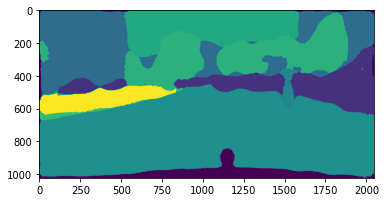

In [ ]:
# Visualize the predicted image with different class
# This array's each pixel has its class id

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(pred_target_output)

plt.show()